# TS8:  Filtrado No Lineal

### Miranda Viceconte

## 1. Introducción 


El filtrado no lineal es una técnica de procesamiento de señales que no cumple con el principio de superposición, ni tampoco cumple con la invariancia en el tiempo, lo que significa que si se desplaza la señal de entrada en el tiempo, la salida no se desplazará de la misma manera. Por eso, los filtros no lineales no pueden representarse usando la convolución ni mediante multiplicación en el dominio Z.

Este tipo de filtrado surge ante la necesidad de eliminar algunos tipos de ruido que no se pueden procesar con metodos lineales. Lo que ocurre es que el filtrado lineal asume que la señal y el ruido están separados en frecuencia, es decir, no se solapan en el espectro. Si esto fuera siempre cierto, uno podría filtrar frecuencias específicas y quedarse solo con la señal, eliminando el ruido.

Esta hipótesis, no es siempre trasladable a la práctica, muchas veces el ruido y la señal comparten frecuencias similares, o sea, se solapan en el dominio de la frecuencia. Por lo que un filtro lineal también va a atenuar partes de la señal junto con el ruido, deformándola o perdiendo información útil. Ademas de que al transformar la señal y el ruido con la Transformada Z, ambos componentes quedan "mezclados", lo que dificulta aislar el ruido con estos métodos.

Este tipo de ruidos se caracterizan por no tener caracteristicas gaussianas, tienden a tener impulsos fuertes y compartir el mismo rango de frecuencias con la señal de interes. 

Ejemplo de solapamiento: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import square

C:\Users\l\AppData\Local\Temp\ipykernel_11892\795146012.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies[bfrec], 20 * np.log10(2 * (fft_noise[bfrec])**2), label='Ruido no gaussiano', alpha=0.7)


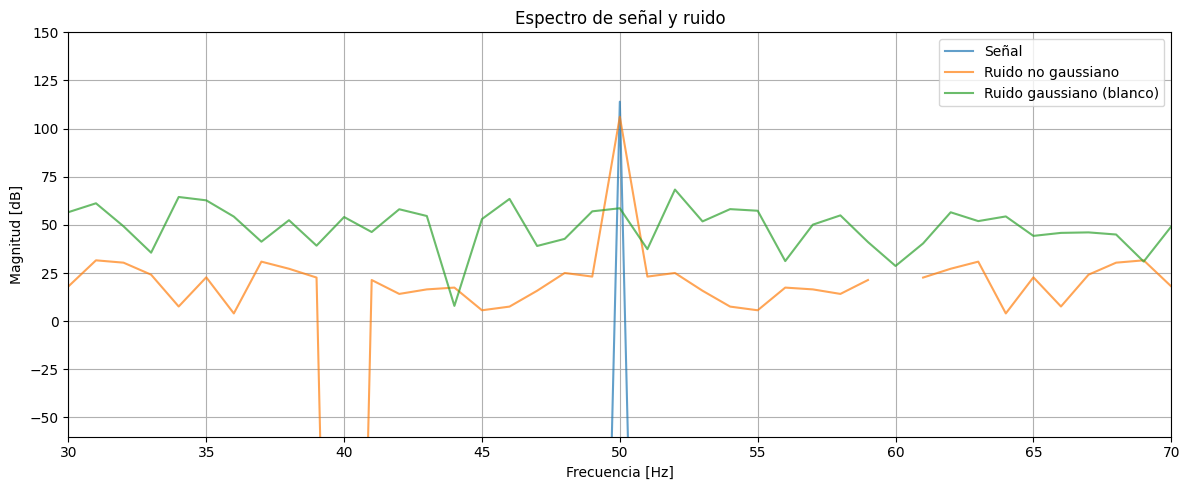

In [4]:
fs = 1000  # frecuencia de muestreo
t = np.linspace(0, 1, fs, endpoint=False)

# Señal: 50 Hz senoidal
signal = np.sin(2 * np.pi * 50 * t)

non_gaussian_noise = 0.5 * square(2 * np.pi * 50 * t)
gaussian_noise = 0.5 * np.random.normal(0, 1, size=t.shape)

# FFT
N = len(t)
frequencies = fftfreq(N, 1/fs)

fft_signal = np.abs(fft(signal))
fft_noise = np.abs(fft(non_gaussian_noise))
fft_gauss = np.abs(fft(gaussian_noise))

# Solo frecuencias positivas
bfrec = frequencies >= 0

# Gráfico
plt.figure(figsize=(12, 5))
plt.plot(frequencies[bfrec], 20 * np.log10(2 * (fft_signal[bfrec])**2), label='Señal', alpha=0.7)
plt.plot(frequencies[bfrec], 20 * np.log10(2 * (fft_noise[bfrec])**2), label='Ruido no gaussiano', alpha=0.7)
plt.plot(frequencies[bfrec], 20 * np.log10(2 * fft_gauss[bfrec]**2), label='Ruido gaussiano (blanco)', alpha=0.7)
plt.xlabel('Frecuencia [Hz]')
plt.xlim(30,70)
plt.ylim(-60, 150)
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de señal y ruido')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Como se puede observar que la señal se mezcla con ruido, la elección de la técnica de filtrado depende fundamentalmente de la naturaleza del ruido y de su ubicación espectral respecto a la señal deseada. 
* Ruido gaussiano (blanco ):  Distribuye su energía de manera uniforme a lo largo de todo el espectro de frecuencias.
* Ruido no gaussiano con picos: Este tipo de ruido se caracteriza por picos abruptos o impulsos en el dominio del tiempo, lo que se traduce en energía distribuida en un amplio rango de frecuencias.
En este caso, un filtro lineal de rechazo de banda podría atenuar la componente fundamental de 50 Hz, el problema es que este tipo de filtro lineal también modifica la morfología de la señal deseada ya que tiene componentes en 50 Hz. 

Generalmente, además de este solapamiento, lo que ocurre es que no se conoce la naturaleza intrínseca del ruido. Teniendo en cuenta que usualmente este tiene distribuida la energía en varias frecuencias, la arquitectura de cualquier filtro convencional puede volverse algo tediosa y poco práctica.

Es por esto que los filtros no lineales se basan principalmente en la estimación del ruido mediante diferentes técnicas para luego eliminarlo:

$$ \hat{x} = s - \hat{b} $$

Donde:  
- $ \hat{x} $ es la señal filtrada, que es una estimación de la señal deseada sin las interferencias.  
- $ \hat{b} $ es la estimación del ruido o interferencia.  
- $ s $ es la señal observada o registrada, que contiene tanto la señal como las interferencias.

Es crucial estimar el ruido porque, a menudo, no podemos simplemente "filtrar" la señal completa con un filtro pasabanda o un filtro notch sin dañar la señal deseada, especialmente si el ruido y la señal se solapan espectralmente o si el ruido tiene características que los filtros lineales no manejan bien (como picos abruptos).

Al estimar el ruido, lo que hacemos es identificar la forma o tendencia de las interferencias, construir una señal lo más parecida posible al ruido, y luego restársela a la señal original. Esto permite cancelarla de forma más efectiva.



### Tipos de filtros no lineales: 

### **Median Filter**

El filtro de mediana trabaja sobre una ventana deslizante de muestras. Para cada punto de salida, se ordenan las muestras dentro de la ventana, y el valor de la mediana se convierte en la salida.

El filtro de mediana, al seleccionar la mediana, es inherentemente robusto frente a valores atípicos. Los picos de alta energía serán ignorados en la ordenación y no afectarán significativamente la mediana, lo que permite una mejor estimación de la señal verdadera.

A diferencia de los filtros pasa-bajos lineales que suavizan y difuminan los bordes, el filtro de mediana es conocido por su capacidad de preservar los bordes de la señal.

La salida filtrada en el instante $t$ mediante un filtro de mediana se puede expresar como:

$$\text{med}_t(s) = \text{mediana}\left( s_{t - k}, \dots, s_t, \dots, s_{t + k} \right)$$

donde $2k + 1$ es el tamaño de la ventana centrada en $t$.

Esta ventana se ajusta según las componentes del ruido que se desean eliminar. Por ejemplo:
- Para oscillaciones rápidas, se utilizan ventanas más cortas.
- Para variaciones lentas, se prefieren ventanas más largas.

Esto permite diferenciar mejor el ruido de la señal, y es ajustable según las necesidades del análisis.

Generalmente, se usan filtros de mediana en cascada, es decir, se eligen dos ventanas de diferentes tamaños y se aplican de forma secuencial:

$$\text{med}_{600} \left( \text{med}_{200}(s) \right)$$

Esto permite que:
- Una ventana se encargue de componentes de gran amplitud (por ejemplo, picos).
- La otra se encargue de oscilaciones más lentas.

Al filtrar de forma progresiva, la estimación se vuelve más precisa y robusta, mejorando la calidad de la señal filtrada.


**Interpolacion con Splines Cubicos** 

### **Interpolación mediante Splines**

La interpolación mediante splines es una técnica poderosa para aproximar funciones suaves y continuas a partir de un conjunto discreto de puntos. A diferencia de un filtro lineal e invariante en el tiempo (LTI), no actúa sobre toda la secuencia como un sistema de procesamiento, sino que construye una curva continua que pasa exactamente por los puntos de datos dados.

Una spline cúbica es una función compuesta por múltiples polinomios de tercer grado definidos por tramos. La clave de su eficacia es que estos polinomios se conectan en los puntos de datos de forma que la función resultante es:
- Continua en su dominio.
- Continua en su primera y segunda derivada.

Esto asegura una curva extremadamente suave, libre de "picos" o "quiebres" abruptos, lo cual es ideal para modelar tendencias suaves o estimaciones de fondo sin distorsionar estructuras locales importantes.

Una vez construida la curva spline que interpola los puntos correspondientes al ruido (por ejemplo, usando puntos seleccionados manualmente o detectados por un método robusto), se remuestrea la spline a la misma frecuencia que la señal original.

Esto se realiza evaluando la spline en cada instante de tiempo $n = 1, 2, \dots, N$, produciendo una señal continua y suave que representa una estimación del ruido:

- Esta estimación tendrá la misma longitud y tasa de muestreo que la señal original.
- Luego, puede restarse de la señal observada para obtener una versión más limpia de la señal deseada.

### Deteccion de Patrones

**Match Filter**

El filtro adaptado es una técnica de procesamiento de señales diseñada para maximizar la relación señal-ruido (SNR) cuando se busca detectar un patrón de pulso conocido inmerso en ruido blanco aditivo.

Detectar la presencia de una forma de onda específica (una plantilla o patrón $p[n]$) dentro de una señal contaminada con ruido.

La respuesta al impulso del filtro adaptado, $h[n]$, se construye como una versión invertida en el tiempo y conjugada del patrón conocido $p[n]$:

- Para señales reales:
  $$
  h[n] = p[N - 1 - n]
  $$
- Para señales complejas:
  $$
  h[n] = p^*[N - 1 - n]
  $$

Donde $N$ es la longitud del patrón.

La salida del filtro adaptado es la convolución entre la señal de entrada $x[n]$ (que contiene la señal $p[n]$ más ruido) y el filtro $h[n]$:

$$
y[n] = x[n] * h[n]
$$

Cuando la señal $x[n]$ contiene el patrón $p[n]$, la salida $y[n]$ tendrá un pico máximo (o mínimo, si el patrón es negativo o invertido) justo en el instante en que ese patrón aparece. Este pico indica el punto de máxima SNR, facilitando la detección.

Su eficacia igualmente depende  de que:
- Tengas una buena representación del patrón que buscás detectar.
- El ruido sea aproximadamente blanco.
- Elijas adecuadamente el umbral de decisión para evitar errores.

El filtro adaptado es una operación de correlación/convolución que te ayuda a identificar dónde está un patrón conocido en una señal ruidosa, maximizando la "distancia" del patrón al ruido en ese punto de detección. Su salida es una "función de detección" que te señala los eventos de interés.


## 2. Código 

In [3]:
#%% Librerias
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio

# Funciones para filtros
from scipy.signal import medfilt
from scipy.interpolate import CubicSpline 
from scipy.signal import correlate, find_peaks

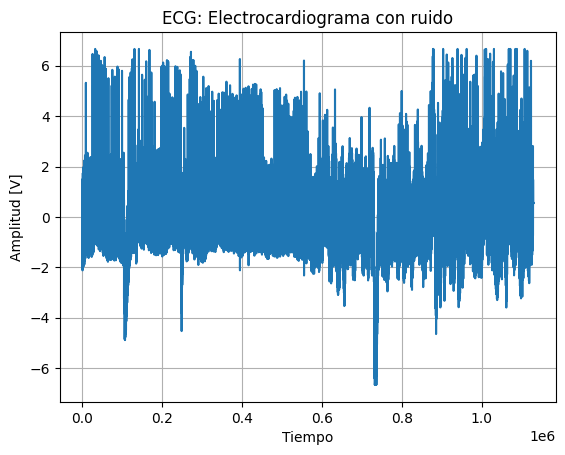

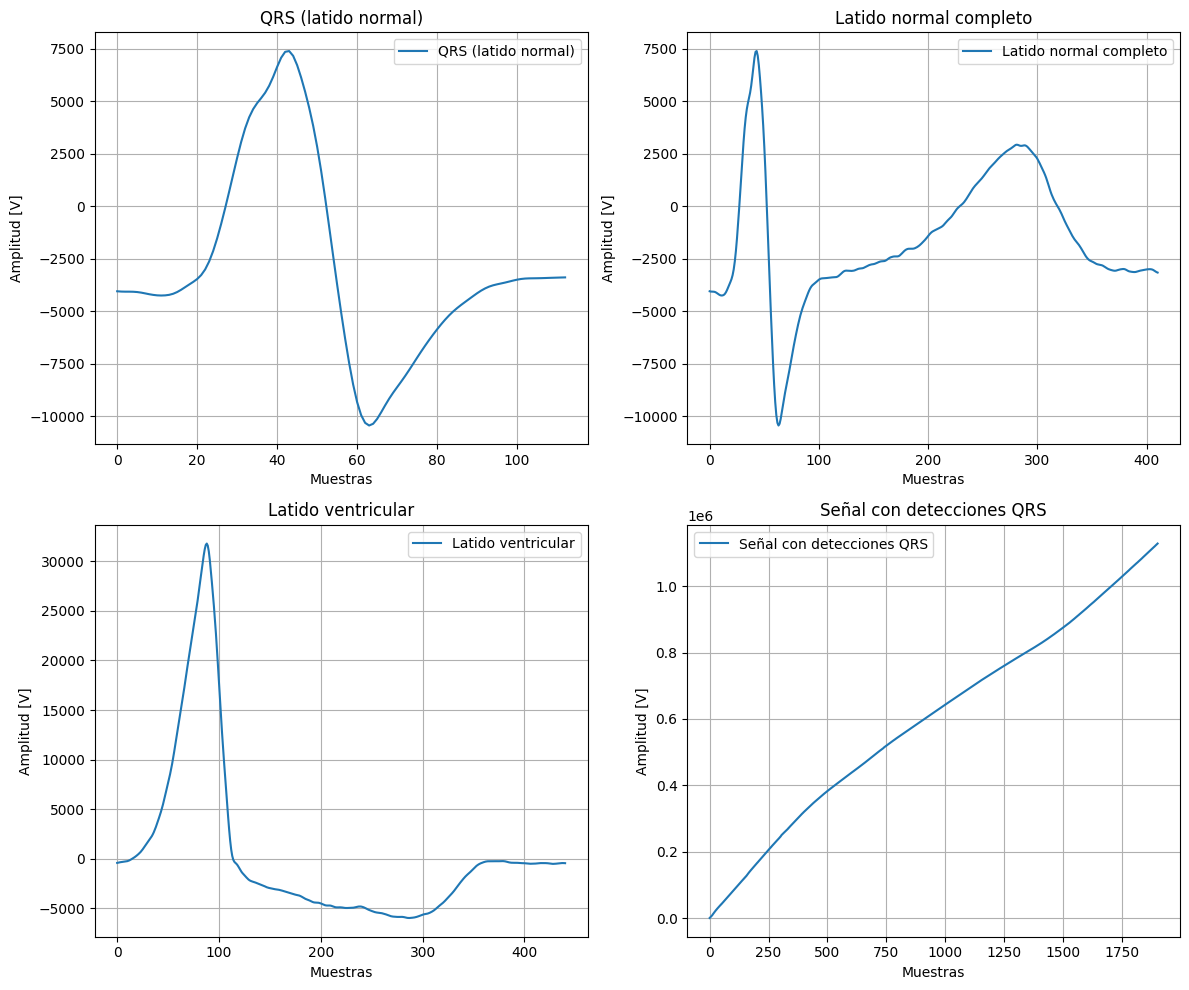

In [4]:
#%% Importamos los datos del ECG

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N1 = len(ecg_one_lead)

# Normalizo la señal: 
ecg_one_lead = ecg_one_lead / np.std(ecg_one_lead)

# Defino variables que voy a analizar dentro del filtro.
qrs_pattern1 = mat_struct['qrs_pattern1'].flatten()
heartbeat_pattern1= mat_struct['heartbeat_pattern1'].flatten()
heartbeat_pattern2 = mat_struct['heartbeat_pattern2'].flatten()
qrs_detections = mat_struct['qrs_detections'].flatten()

# Visualizacion de la señal en tiempo 
plt.figure() 
plt.plot(ecg_one_lead, label= 'Señal de ECG completa')
plt.title("ECG: Electrocardiograma con ruido")
plt.xlabel('Tiempo')
plt.ylabel('Amplitud [V]')
plt.grid(True)

seniales = {
    'QRS (latido normal)': qrs_pattern1,
    'Latido normal completo': heartbeat_pattern1,
    'Latido ventricular': heartbeat_pattern2,
    'Señal con detecciones QRS': qrs_detections
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=False)
axs = axs.flatten()

for idx, (titulo, senial) in enumerate(seniales.items()):
    axs[idx].plot(senial, label=titulo)
    axs[idx].set_title(f'{titulo}')
    axs[idx].set_xlabel('Muestras')
    axs[idx].set_ylabel('Amplitud [V]')
    axs[idx].grid(True)
    axs[idx].legend()

plt.tight_layout()
plt.show()

### Diseño de filtros

### Mediana

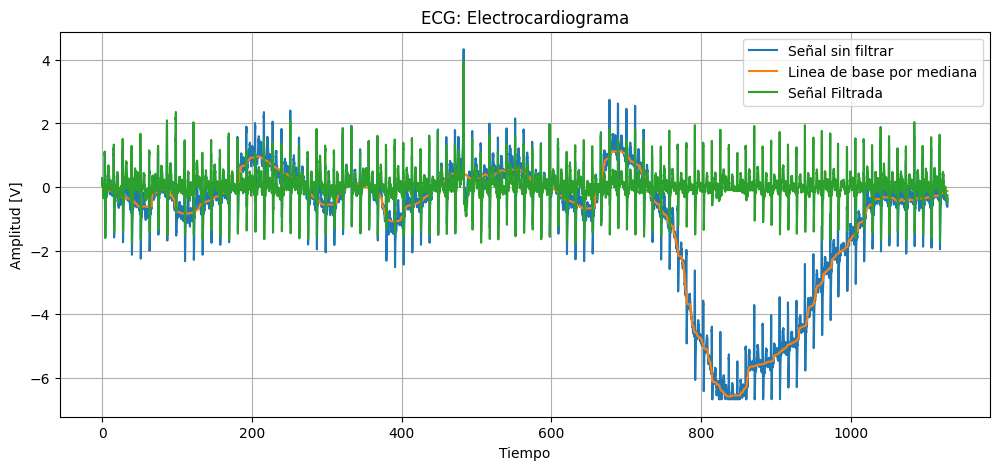

In [5]:
#Segmento de interes: 
fs = 1000 # Hz
ecg_segment= ecg_one_lead[700000:745000]
t_segment=np.linspace(0, len(ecg_one_lead)/ fs, len(ecg_segment))

#Ventana
win1=201
win2=1201

# Filtro de mediana (200ms)
base_line= sig.medfilt(ecg_segment, kernel_size=win1)

# Filtro de mediana (600ms)
base_line2=sig.medfilt(base_line, kernel_size=win2)

#Filtramos la señal
x_hat = ecg_segment - base_line2

#Visualizacion
plt.figure(figsize=(12,5)) 
plt.plot(t_segment,ecg_segment, label= 'Señal sin filtrar')
plt.plot(t_segment, base_line2, label='Linea de base por mediana')
plt.plot(t_segment, x_hat, label='Señal Filtrada')
plt.title("ECG: Electrocardiograma")
plt.xlabel('Tiempo')
plt.ylabel('Amplitud [V]')
plt.legend()
plt.grid(True)
plt.show()

### Interpolación 

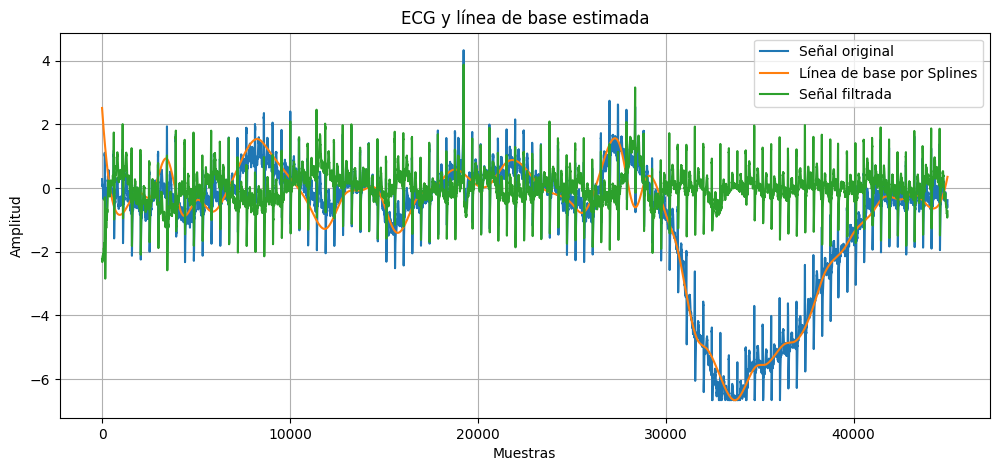

In [6]:
n0 = int(0.1 * fs) # --> Defnimos en funcion de fs para que este muestreada a la misma frecuencia el baseline
ecg_segment= ecg_one_lead[700000:745000]

# Calculo los mi = ni - n0 (segmento PQ) ni punto maximo detecto el qrs para asi desfasarme y encontrar el nivel isoelectrico
# --> Estos son los tiempos (en muestras) a las que ocurren las detecciones del qrs
m_i = qrs_detections - n0
m_i = m_i[(m_i >= 0) & (m_i < len(ecg_segment))]

# ---> Esta es la señal a esos tiempos m_i
s_mi = ecg_segment[m_i]

# Interpolamos con spline cúbico
spline = CubicSpline(m_i, s_mi)
# Evaluamos el spline en todos los puntos 
n = np.arange(len(ecg_segment))
base_spline = spline(n)

# Filtramos la señal 
x_hat2 = ecg_segment - base_spline

plt.figure(figsize=(12, 5))
plt.plot(ecg_segment, label='Señal original')
plt.plot(base_spline, label='Línea de base por Splines')
plt.plot(x_hat2, label='Señal filtrada')
plt.legend()
plt.title("ECG y línea de base estimada")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

### Match Filter

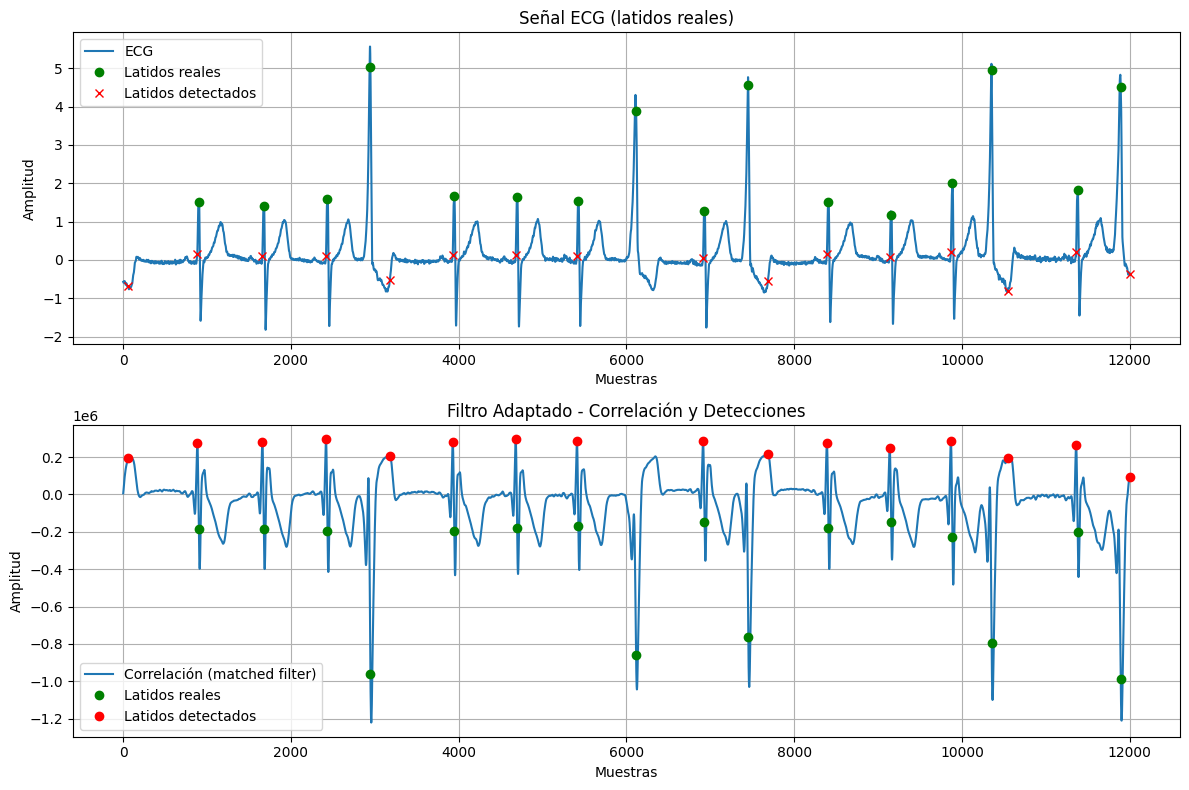

In [7]:
# Segmento de ECG
ecg_segment = ecg_one_lead[300000:312000]

# Invierto el patrón del filtro adaptado
h = qrs_pattern1[::-1]

# Correlación en modo 'same' para que tenga el mismo largo que ecg_segment
correlation = correlate(ecg_segment, h, mode='same')

# Detección de picos en la correlación
peaks, _ = find_peaks(correlation, height=np.max(correlation)*0.3, distance=int(fs*0.6))

# Picos verdaderos dentro del segmento (convertidos a relativo al segmento)
peaks_true = qrs_detections[(qrs_detections >= 300000) & (qrs_detections < 312000)] - 300000


# Visualizacion 
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(ecg_segment, label='ECG')
axs[0].plot(peaks_true, ecg_segment[peaks_true], 'go', label='Latidos reales')
axs[0].plot(peaks, ecg_segment[peaks], 'rx', label='Latidos detectados')
axs[0].set_title('Señal ECG (latidos reales)')
axs[0].set_xlabel('Muestras')
axs[0].set_ylabel('Amplitud')
axs[0].grid(True)
axs[0].legend()

# Correlación con detección de picos
axs[1].plot(correlation, label='Correlación (matched filter)')
axs[1].plot(peaks_true, correlation[peaks_true], 'go', label='Latidos reales')
axs[1].plot(peaks, correlation[peaks], 'ro', label='Latidos detectados')
axs[1].set_title('Filtro Adaptado - Correlación y Detecciones')
axs[1].set_xlabel('Muestras')
axs[1].set_ylabel('Amplitud')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

In [8]:

# Métricas
tolerancia = int(0.10 * fs)  # 100 ms de tolerancia

TP = 0
FP = 0
FN = 0

# Creamos array para marcar qué latidos reales ya fueron emparejados
true_matched = np.zeros_like(peaks_true, dtype=bool)

# Comparar cada pico detectado con los verdaderos
for p in peaks:
    match = False
    for i, pt in enumerate(peaks_true):
        if not true_matched[i] and abs(p - pt) <= tolerancia:
            TP += 1
            true_matched[i] = True
            match = True
            break
    if not match:
        FP += 1

# Lo que no fue emparejado se considera FN
FN = np.sum(~true_matched)

# Cálculo de métricas
if TP + FN > 0:
    sensibilidad = TP / (TP + FN)
else:
    sensibilidad = 0.0

if TP + FP > 0:
    precision = TP / (TP + FP)
else:
    precision = 0.0

# Mostrar resultados
print(f"Latidos reales detectados correctamente (TP): {TP}")
print(f"Falsos positivos (FP): {FP}")
print(f"Falsos negativos (FN): {FN}")
print(f"Sensibilidad (Recall): {sensibilidad:.2%}")
print(f"Precisión (PPV): {precision:.2%}")

Latidos reales detectados correctamente (TP): 11
Falsos positivos (FP): 5
Falsos negativos (FN): 5
Sensibilidad (Recall): 68.75%
Precisión (PPV): 68.75%


# 3. Analisis

Primero en el filtro de mediana, podemos observar que la señal sin filtrar exhibe una significativa deriva de la línea de base, manifestada por un desplazamiento vertical notable, especialmente visible entre los 700 y 1000 segundos, donde la amplitud disminuye considerablemente. La estimación de la línea de base sigue de cerca las variaciones de baja frecuencia, capturando eficazmente esta deriva. Al restar esta estimación de la señal original, se logra una eliminación exitosa de los componentes de baja frecuencia, resultando en una señal centrada alrededor de cero.

Por otro lado, la estimación de la línea de base mediante interpolación de Splines sigue fielmente el comportamiento de la señal en la zona de baja frecuencia. Sin embargo, es importante destacar que en algunos puntos específicos, la curva de la spline no coincide perfectamente con la forma de la señal contaminada en las zonas de alta frecuencia o de transiciones rápidas. Esto se debe a que las splines buscan crear una curva continua y suave a través de puntos de control definidos. Aunque esto proporciona una estimación global más suave de la línea de base en comparación con un filtro de mediana, puede no capturar las variaciones más rápidas. No obstante, en líneas generales, el filtrado con splines es óptimo.

Con respecto al diseño de filtros adaptados para la detección de patrones, la señal de correlación muestra picos muy claros y distintivos justo en las ubicaciones de los QRS. Esto confirma la efectividad del patrón de QRS utilizado y que la operación de correlación está funcionando adecuadamente para resaltar estos eventos. Visualmente, se observa una buena capacidad para identificar los complejos QRS, evidenciada por la alineación entre los latidos reales (círculos verdes) y los detectados (cruces/círculos rojos) en ambos gráficos, siendo los picos de correlación ideales para la detección.

Sin embargo, las métricas cuantitativas revelan áreas de mejora. Una Sensibilidad y Precisión del 75% indican que, aunque la mayoría de los latidos se detectan correctamente (11 Verdaderos Positivos), el sistema no es perfecto. Los 5 Falsos Positivos (FP) sugieren que el detector ocasionalmente confunde ruido o artefactos con un QRS, mientras que los 5 Falsos Negativos (FN) señalan que algunos latidos reales no fueron detectados, posiblemente por su morfología atípica o por no alcanzar el umbral de correlación.

Para mejorar la precisión y sensibilidad del detector de QRS, es crucial ajustar el umbral de detección (height) y el parámetro de distancia (distance) de find_peaks, ya que nuestras métricas actuales (68% de sensibilidad y precisión) y los gráficos sugieren que un umbral no óptimo puede generar falsos positivos (por ruido que cruza el umbral) o falsos negativos (por picos reales que no lo alcanzan), mientras que la distancia inadecuada podría causar detecciones perdidas o redundantes.Además, es importante destacar que en la práctica clínica, una sensibilidad del 68% para una señal de ECG no es óptima; lo deseable es alcanzar un rango del 90-95% para evitar la omisión de detalles morfológicos cruciales y minimizar los falsos positivos, los cuales podrían tener serias implicaciones médicas.

Además, un pre-filtrado de la señal antes de la correlación es necesario para suavizar el ruido de alta frecuencia, que, aunque de baja amplitud, actualmente puede enmascarar picos reales o generar falsos positivos en la salida de la correlación, impactando directamente en la robustez de la detección.

### BONUS: ¿Podría funcionar el detector basado en el filtro adaptado con un latido perteneciente a otro registro o paciente?

La morfología del complejo QRS (su forma, duración, amplitud de las ondas Q, R y S) es altamente individual. Depende de factores como la anatomía cardíaca de cada persona, la posición de los electrodos, la edad, el sexo, la presencia de enfermedades cardíacas (ej. hipertrofia, infartos previos), e incluso la fase de la respiración. Un filtro adaptado funciona correctamente cuando el patron que se usa para la correlación es muy similar a la señal que se busca. Si el patron se obtuvo de un paciente A, este está determinado por la forma particular de los QRS de ese paciente. En consecuencia,  el valor de la correlación máxima será menor. Esto puede hacer que los picos de correlación de los QRS del paciente B no alcancen el umbral de detección, resultando en una alta cantidad de Falsos Negativos (FN).Alternativamente, si el umbral se baja demasiado para intentar capturar estos QRS de baja correlación, se corre el riesgo de aumentar drásticamente los Falsos Positivos (FP).
En conclusion probablemente no funcionaría de forma óptima con un latido de otro registro o paciente sin alguna forma de adaptación o generalización de la plantilla.